# DSCI 100 Project Final Report

#### Names: Jasleen Jhajj, Josh Mitra, Angelina Chen, Lucy Dobbin

#### Student IDs: 98671837, 36999878, 73855355

---
## Introduction

A UBC Computer Science research group is studying how people play video games, focusing on Minecraft. They set up a Minecraft server to track player actions, collecting data in two files: players.csv and sessions.csv. The players.csv dataset contains 7 variables and 194 observations, capturing information such as total playtime (played_hours), experience level (experience), and whether the player subscribed to the newsletter (subscribe). The sessions.csv dataset contains 5 variables and 1533 observations, tracking individual gameplay sessions with start and end times, as well as player IDs.

Some issues with the raw data had to be addressed before analysis. Several players had 0 recorded playtime, which interfered with visualizations and modeling. The hashedEmail column is difficult to interpret due to its unreadable format. In the sessions.csv file, the original_start_time and original_end_time columns are ambiguous, and the start_time and end_time columns contain two values in each cell, making the data untidy.

The question we tried to answer in our project was: Does a player's playtime (played_hours), experience level (experience), and number of sessions (number_of_sessions) predict their likelihood of subscribing to the newsletter (subscribe)? These variables represent key aspects of player behavior, including engagement, skill level, and play habits.

To prepare the data for modeling, we scaled numerical values, encoded categorical variables, and handled missing or unclear data. These preprocessing steps helped ensure the model could detect meaningful patterns and make accurate predictions.

---
## Methods & Results

In [1]:
# Importing libraries
library(tidyverse)
library(tidymodels)
library(repr)
library(RColorBrewer)
library(ggplot2)
library(forcats)
library(lubridate)

#Limit output of dataframes to 6 frames
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
players <- read_csv("https://raw.githubusercontent.com/JasleenJhajj/toy_ds_project/refs/heads/main/players.csv")
players
sessions <- read_csv("https://raw.githubusercontent.com/JasleenJhajj/toy_ds_project/refs/heads/main/sessions.csv")
sessions

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,28/07/2024 15:36,28/07/2024 15:57,1.72218e+12,1.72218e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,25/07/2024 06:15,25/07/2024 06:22,1.72189e+12,1.72189e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,20/05/2024 02:26,20/05/2024 02:45,1.71617e+12,1.71617e+12


In [3]:
# Determine if there are missing values in each dataset
cat("\nMissing values in players.csv:\n")
print(colSums(is.na(players)))

# Determine the unique values for categorical variables in players
cat("\nUnique values in 'experience':\n")
print(unique(players$experience))

cat("\nUnique values in 'gender':\n")
print(unique(players$gender))


Missing values in players.csv:
  experience    subscribe  hashedEmail played_hours         name       gender 
           0            0            0            0            0            0 
         Age 
           2 

Unique values in 'experience':
[1] "Pro"      "Veteran"  "Amateur"  "Regular"  "Beginner"

Unique values in 'gender':
[1] "Male"              "Female"            "Non-binary"       
[4] "Prefer not to say" "Agender"           "Two-Spirited"     
[7] "Other"            


In [4]:
# Summary statistics for quantitative variables in the players data set

players_summarized <- players |>
summarize (total_players = n(),
           mean_age = mean(Age, na.rm = TRUE),
           median_age = median(Age, na.rm = TRUE),
           sd_age = sd(Age, na.rm = TRUE),
           min_age = min(Age, na.rm = TRUE),
           max_age = max(Age, na.rm = TRUE),
           mean_hours = mean(played_hours, na.rm = TRUE),
           median_hours = median(played_hours, na.rm = TRUE),
           sd_hours = sd(played_hours, na.rm = TRUE),
           min_hours = min(played_hours, na.rm = TRUE),
           max_hours = max(played_hours, na.rm = TRUE))
players_summarized

total_players,mean_age,median_age,sd_age,min_age,max_age,mean_hours,median_hours,sd_hours,min_hours,max_hours
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
196,20.52062,19,6.174667,8,50,5.845918,0.1,28.35734,0,223.1


In [5]:
# Clean NA values from players data set
clean_players <- players |>
filter(!is.na(experience), !is.na(subscribe), !is.na(hashedEmail), !is.na(played_hours), !is.na(Age))

# Clean NA values from sessions data set
clean_sessions <- sessions |>
filter(!is.na(hashedEmail), !is.na(original_start_time), !is.na(original_end_time))

In [6]:
# Create new column called number_of_sessions (Total number of sessions played per player)

sessions_player <- clean_sessions |>
group_by(hashedEmail) |>
summarize(number_of_sessions = n(), .groups = "drop")

# Merge players and sessions data sets
# Remove players without any sessions
players_combined <- clean_players |>
left_join (sessions_player, by = "hashedEmail") |>
filter (!is.na(number_of_sessions))

# Convert `experience` from a Character to a Factor using as.factor function
players_combined$experience <- as.factor(players_combined$experience)

#Final data set
players_final <- players_combined |>
select(played_hours, number_of_sessions, subscribe, experience)
players_final

played_hours,number_of_sessions,subscribe,experience
<dbl>,<int>,<lgl>,<fct>
30.3,27,TRUE,Pro
3.8,3,TRUE,Veteran
0.0,1,FALSE,Veteran
⋮,⋮,⋮,⋮
0.3,1,FALSE,Veteran
0.0,1,FALSE,Amateur
2.3,6,FALSE,Amateur


In [7]:
# wrangle data
players_final$experience <- as.numeric(as.factor(players_final$experience))
players_final$subscribe <- as.factor(players_final$subscribe)
players_final

played_hours,number_of_sessions,subscribe,experience
<dbl>,<int>,<fct>,<dbl>
30.3,27,TRUE,3
3.8,3,TRUE,5
0.0,1,FALSE,5
⋮,⋮,⋮,⋮
0.3,1,FALSE,5
0.0,1,FALSE,1
2.3,6,FALSE,1


In [8]:
# knn
# Can a player's playtime (played_hours), experience level (experience), and number of sessions (number_of_sessions) predict their likelihood of subscribing to the newsletter (subscribe)?
set.seed(3456) 
players_split <- initial_split(players_final, prop = 0.75, strata = subscribe)  
players_train <- training(players_split)   
players_test <- testing(players_split)

players_train
players_test

played_hours,number_of_sessions,subscribe,experience
<dbl>,<int>,<fct>,<dbl>
0.0,1,FALSE,5
0.1,1,FALSE,1
1.4,6,FALSE,5
⋮,⋮,⋮,⋮
0.8,1,TRUE,1
32.0,79,TRUE,1
0.1,1,TRUE,5


played_hours,number_of_sessions,subscribe,experience
<dbl>,<int>,<fct>,<dbl>
0.7,1,TRUE,1
0.0,1,FALSE,1
0.1,1,TRUE,1
⋮,⋮,⋮,⋮
0.4,1,FALSE,3
0.1,1,TRUE,5
0.3,1,FALSE,5


In [9]:
set.seed(2020)

players_recipe <- recipe(subscribe ~ played_hours + number_of_sessions + experience, data = players_train) |>
   step_scale(all_predictors()) |>
   step_center(all_predictors())

players_recipe



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 3



── Operations 

• Scaling for: all_predictors()

• Centering for: all_predictors()



In [10]:
set.seed(2020)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
      set_engine("kknn") |>
      set_mode("classification")

players_fit <- workflow() |>
      add_recipe(players_recipe) |>
      add_model(knn_spec) |>
      fit(data = players_train)
players_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(3,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.3152174
Best kernel: rectangular
Best k: 3

In [11]:
players_test_predictions <- predict(players_fit , players_test) |>
      bind_cols(players_test)

players_test_predictions

.pred_class,played_hours,number_of_sessions,subscribe,experience
<fct>,<dbl>,<int>,<fct>,<dbl>
TRUE,0.7,1,TRUE,1
TRUE,0.0,1,FALSE,1
FALSE,0.1,1,TRUE,1
⋮,⋮,⋮,⋮,⋮
TRUE,0.4,1,FALSE,3
FALSE,0.1,1,TRUE,5
FALSE,0.3,1,FALSE,5


In [12]:
set.seed(2020)
players_prediction_accuracy <- players_test_predictions |>
        metrics(truth = subscribe, estimate = .pred_class)             

players_prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.48387097
kap,binary,-0.08296943


In [13]:
set.seed(2020)

players_mat <- players_test_predictions |> 
      conf_mat(truth = subscribe, estimate = .pred_class)

players_mat

          Truth
Prediction FALSE TRUE
     FALSE     3   11
     TRUE      5   12

In [14]:
set.seed(2020)
players_vfold <- vfold_cv(players_train, v = 10, strata = subscribe)

In [15]:
set.seed(2020)
players_resample_fit <- workflow() |>
      add_recipe(players_recipe) |>
      add_model(knn_spec) |>
      fit_resamples(resamples = players_vfold)

In [16]:
players_metrics <- players_resample_fit %>%
    collect_metrics()
players_metrics

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,binary,0.5913889,10,0.05569496,Preprocessor1_Model1
roc_auc,binary,0.5315476,10,0.08213447,Preprocessor1_Model1


In [17]:
set.seed(2020)
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
      set_engine("kknn") |>
      set_mode("classification")
knn_tune

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [18]:
set.seed(1234)

k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

knn_results <- workflow() |>
      add_recipe(players_recipe) |>
      add_model(knn_tune) |>
      tune_grid(resamples = players_vfold, grid = k_vals) |>
      collect_metrics()

knn_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5788889,10,0.06088088,Preprocessor1_Model01
1,roc_auc,binary,0.5428571,10,0.06140416,Preprocessor1_Model01
2,accuracy,binary,0.5788889,10,0.06088088,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
9,roc_auc,binary,0.5916667,10,0.07134144,Preprocessor1_Model09
10,accuracy,binary,0.6227778,10,0.03833333,Preprocessor1_Model10
10,roc_auc,binary,0.5416667,10,0.07420210,Preprocessor1_Model10


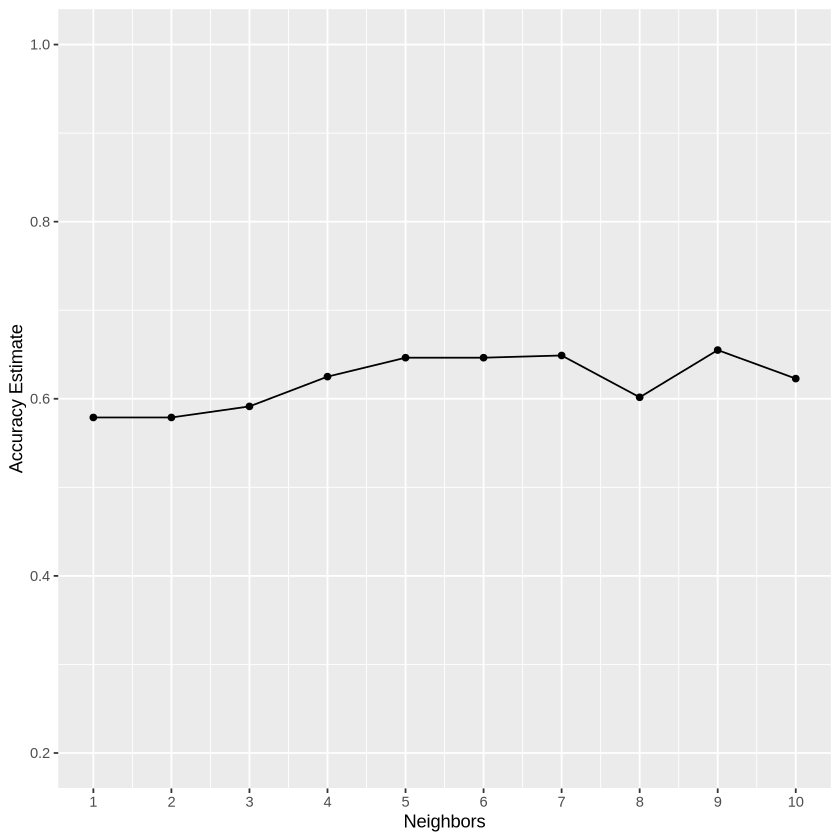

In [19]:
accuracies <- knn_results |> 
      filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.2, 1.0)) # adjusting the y-axis

accuracy_versus_k

In [20]:
set.seed(2020)

knn_spec_7 <- nearest_neighbor(weight_func = "rectangular", neighbors = 8) |>
      set_engine("kknn") |>
      set_mode("classification")

players_fit_7 <- workflow() |>
      add_recipe(players_recipe) |>
      add_model(knn_spec_7) |>
      fit(data = players_train)
players_fit_7

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(8,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.3043478
Best kernel: rectangular
Best k: 8

In [21]:
players_test_predictions_7 <- predict(players_fit_7 , players_test) |>
      bind_cols(players_test)

players_test_predictions_7

.pred_class,played_hours,number_of_sessions,subscribe,experience
<fct>,<dbl>,<int>,<fct>,<dbl>
TRUE,0.7,1,TRUE,1
TRUE,0.0,1,FALSE,1
TRUE,0.1,1,TRUE,1
⋮,⋮,⋮,⋮,⋮
TRUE,0.4,1,FALSE,3
FALSE,0.1,1,TRUE,5
FALSE,0.3,1,FALSE,5


In [22]:
set.seed(2020)

players_mat_7 <- players_test_predictions_7 |> 
      conf_mat(truth = subscribe, estimate = .pred_class)

players_mat_7

          Truth
Prediction FALSE TRUE
     FALSE     2    6
     TRUE      6   17

---
## Discussion

In this project, we looked at whether Minecraft player behavior could help predict if a player would subscribe to the game’s newsletter. We focused on three features: total playtime (played_hours), number of sessions (number_of_sessions), and experience level (experience). Using these, we built a K-Nearest Neighbors (KNN) classification model to predict whether or not a player subscribed.

During the cleaning process, we noticed a few issues—some players had 0 recorded play hours, and some session times were messy or incomplete. After filtering out those inconsistencies, we split the data, scaled the features, and used 10-fold cross-validation to evaluate the model. Through hyperparameter tuning, we found that using 8 neighbors gave the best accuracy.

The model showed that player engagement was a useful predictor for subscription. This made sense, as more active or experienced players are likely to be more interested in game updates or community content.

These results could be useful for developers or marketing teams trying to grow newsletter engagement. If they can identify highly engaged players early on, they could focus their efforts on those users to increase subscriptions and keep players coming back.

This project also raises a few interesting questions for the future:

* Would adding demographic info like age or gender improve predictions?
* Could more complex models (like decision trees or ensembles) outperform KNN?
* Could we also predict in-game purchases or other actions based on session data?
* Overall, this project shows that even simple models can uncover meaningful patterns in user behavior, and gameplay data has real potential to drive better engagement strategies.